# Summary of DECK experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import foci_functions

In [2]:
# Read CO2
exps = ['FOCI_GJK029',
        'FOCI_GJK030_r1i1p1',
        'FOCI_GJK031_r1i1p1',
        'FOCI_GJK032_r3i1p1']
names = ['piControl','historical','abrupt-4xCO2','1pctCO2']

ds_list = []
for i,exp in enumerate(exps):
    ds = xr.open_dataset('data/%s_forcing.nc' % (exp,), use_cftime=True)
    ds['expname'] = names[i]
    ds_list.append(ds)

In [3]:
# Read OpenIFS data
time_list = [slice('2450-01-01','2600-01-01'),
             slice('1850-01-01','2015-01-01'),
             slice('1850-01-01','2000-01-01'),
             slice('1850-01-01','1990-01-01')]

ds_sfc = foci_functions.read_openifs(exps, time_list, freq='1y')

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK030_r1i1p1/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK031_r1i1p1/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK032_r3i1p1/outdata/oifs/ym/*1y*regular_sfc.nc


In [4]:
# piControl is 150 years but calendar makes no sense
# replace here
new_time = ds_sfc[2]['time']

In [5]:
ds_sfc[0]['time'] = new_time

In [6]:
# Read AMOC data
ds_amoc = foci_functions.read_amoc(exps, time_list)
# set new calendar so that 2450-2600 in piCtrl becomes 1850-2000
ds_amoc[0]['time'] = new_time

In [7]:
# Read ice data
ds_lim_1y = foci_functions.read_nemo(exps, time_list, grid='icemod',freq='1y')
ds_lim_1y[0]['time'] = new_time

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/nemo/ym/FOCI_GJK029*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK030_r1i1p1/outdata/nemo/ym/FOCI_GJK030_r1i1p1*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK031_r1i1p1/outdata/nemo/ym/FOCI_GJK031_r1i1p1*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK032_r3i1p1/outdata/nemo/ym/FOCI_GJK032_r3i1p1*1y*icemod.nc


In [8]:
# Compute sea-ice area
nemo_mesh = foci_functions.read_nemo_mesh()

ds_ice = []
for i,ds in enumerate(ds_lim_1y):
    _ds = foci_functions.seaice_areas(ds, 
                                      nemo_mesh['tarea'], 
                                      nemo_mesh['tmask'].isel(deptht=0))
    ds_ice.append(_ds.compute())

In [ ]:
# Compute global mean
tmean_list = [] 
for ds in ds_sfc:
    tm = foci_functions.global_mean(ds['2t'])
    tmean_list.append(tm.compute())

In [15]:
# Compute global mean
toa_list = [] 
for i,ds in enumerate(ds_sfc):
    
    # rescale from J/m2 to W/m2
    # but not for 1pctCO2 where it was already done
    if exps[i] == 'FOCI_GJK032_r3i1p1':
        scale = 1
    else:
        scale = 6.0*3600
        
    tm = foci_functions.global_mean((ds['tsr'] + ds['ttr'])/scale)
    toa_list.append(tm.compute())

In [22]:
# Compute global mean
tp_list = [] 
for i,ds in enumerate(ds_sfc):
    
    if exps[i] == 'FOCI_GJK032_r3i1p1':
        # convert from m/s to mm/day
        scale = 1000 * 86400
    else:
        # convert from m/6hr to mm/day
        scale = 86400 / (6.0*3600) * 1000
        
    tp = foci_functions.global_mean(ds['tp']*scale)
    tp_list.append(tp.compute())

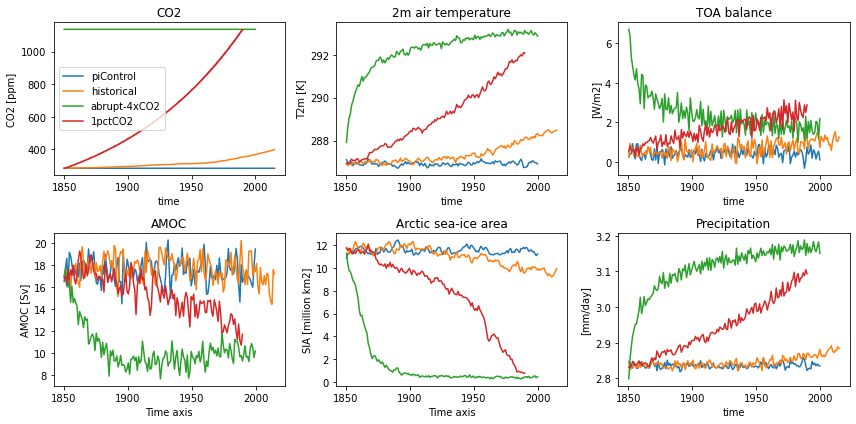

In [23]:
# Plot

# select times
times = slice('1850-01-01','2015-01-01')

fig, ax = plt.subplots(2,3, figsize=(12,6))
axs = ax.flat

for i,ds in enumerate(ds_list):
    ds['co2'].sel(time=times).plot(ax=axs[0], label=names[i])
    
for i,tm in enumerate(tmean_list):
    tm.plot(ax=axs[1])

for i,tm in enumerate(toa_list):
    tm.plot(ax=axs[2])    
    
for i,amoc in enumerate(ds_amoc):
    amoc['amoc25'].plot(ax=axs[3])

for i,ice in enumerate(ds_ice):
    ice['ar_sia'].plot(ax=axs[4])
    
for i,tp in enumerate(tp_list):
    tp.plot(ax=axs[5])
    
axs[0].legend()
axs[0].set_title('CO2')
axs[0].set_ylabel('CO2 [ppm]')

axs[1].set_title('2m air temperature')
axs[1].set_ylabel('T2m [K]')

axs[2].set_title('TOA balance')
axs[2].set_ylabel('[W/m2]')

axs[3].set_title('AMOC')
axs[3].set_ylabel('AMOC [Sv]')

axs[4].set_title('Arctic sea-ice area')
axs[4].set_ylabel('SIA [million km2]')

axs[5].set_title('Precipitation')
axs[5].set_ylabel('[mm/day]')

fig.tight_layout()
fig.savefig('plots/deck_runs_summary.pdf',format='pdf')